In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from paretoset import paretoset
import pickle

import pickle
import sys
sys.path.append('../')
sys.path.append('../usecase_cd')
sys.path.append('../src')
import src
import utils 
from plotting_tools import read_pkl_surrogate

plt.style.use("seaborn-v0_8-paper")

font = 16
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font,
    'axes.titlesize': font
})
import warnings
warnings.filterwarnings("ignore")

/var/folders/d5/3r233ss93fv98nxsrp4wy_hc0000gn/T/ipykernel_4462/595482114.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Tutorial: Analysis of collected Pareto frontier 

This notebook serves as tutorial for analysing solutions for multiple-optimization objectives (=Pareto frontier).
1. We will look into how we can retrieve these solutions of a random 2D sample set.
2. We will investigate our smallest network topology, the (2,1)-tree.

### 1. Pareto front of a random 2D sample set 

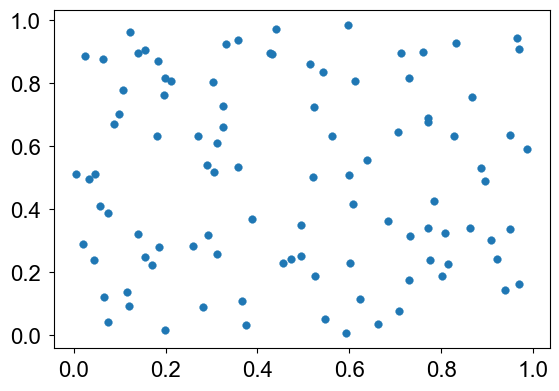

In [12]:
a = 0
b = 1
sample = (b-a) * np.random.random_sample((2,100)) + a
plt.scatter(x=sample[0], y=sample[1])
plt.show()

The Pareto frontier of the collected sample can be easiliy retrieved with `paretoset()` and is marked in orange below.

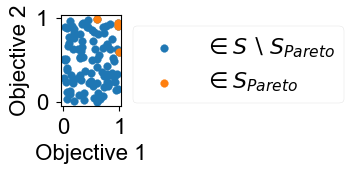

In [13]:
filter = paretoset(sample.T, sense=["max", "max"])
fig, ax = plt.subplots(figsize=[4,2])
plt.ylabel('Objective 2')
plt.xlabel('Objective 1')
plt.scatter(x=sample[0], y=sample[1], label=r'$\in S\setminus S_{Pareto}$')
plt.scatter(x=sample[0][filter], y=sample[1][filter], label=r'$\in S_{Pareto}$')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('simple-pareto.pdf')

### 2. Pareto analysis of (2,1)-tree of collected solution set

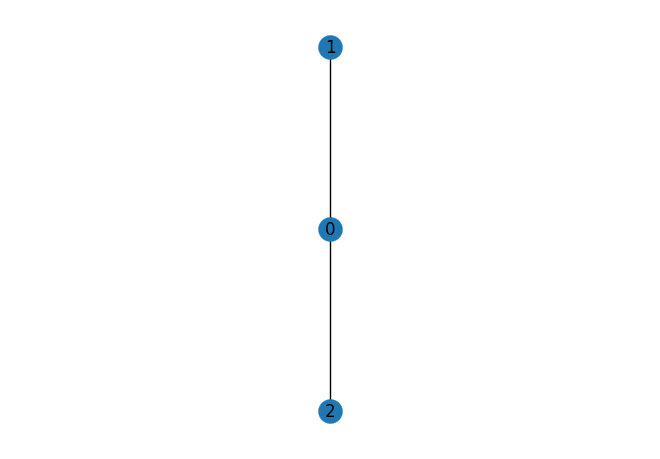

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(2, 1)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos, with_labels=True)
plt.show()

Load solution from `surdata` or run `sur.py --topo 2,1 --time 0.5` (30 min runtime). `config.py` is set with the following parameters

* 'protocol': 'ndsrs',
* 'p_gen': 0.9,
* 'p_swap': 1,
* 'return_data': 'avg',
* 'progress_bar': None,
* 'total_time': 1000,
* 'N_samples': 1000,
* 'p_cons': 0.225,
* 'qbits_per_channel': 5,
* 'cutoff': 28,
* 'M': 2,
* 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])

In [15]:
with open('../../surdata/SU_tree-2-1_20iterator_objective-meanopt_SEED42_04-23-2024_17:56:17.pkl', 'rb') as file: 
    # Load the object from the file
    sur_loaded_data = pickle.load(file)
model = sur_loaded_data

In [16]:
model.vals

{'protocol': 'ndsrs',
 'p_gen': 0.9,
 'p_swap': 1,
 'return_data': 'avg',
 'progress_bar': None,
 'total_time': 1000,
 'N_samples': 1000,
 'p_cons': 0.225,
 'qbits_per_channel': 5,
 'cutoff': 28,
 'M': 2,
 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])}

In [17]:
# How to calculate which cutoff time to set (given total runtime T, M, Fnew and Fapp)
T = 1000
M = 4
Fnew = 0.888
Fapp = 0.6
-T*np.log( 3/(4*Fnew-1) * ((4*Fapp-1)/3)**(1/M) )

28.800089826157972

In [18]:
virtual_neighbours = pd.DataFrame(model.y) # N = 1000
virtual_neighbours.columns = [f'User {i}' for i in range(3)]
virtual_neighbours = virtual_neighbours[['User 0', 'User 1', 'User 2']]
virtual_neighbours

,User 0,User 1,User 2
0,0.243243,1.123123,1.120120
1,0.978979,1.464464,1.470470
2,0.162162,1.085085,1.077077
3,0.380380,1.188188,1.190190
4,1.993994,1.302302,1.302302
...,...,...,...
185,1.879880,1.638639,1.636637
186,1.856857,1.612613,1.613614
187,1.850851,1.611612,1.610611
188,1.859860,1.630631,1.638639


In [19]:
vn = virtual_neighbours.to_numpy()
filter = paretoset(vn, sense=["max"]*3)
print(len(filter))

190


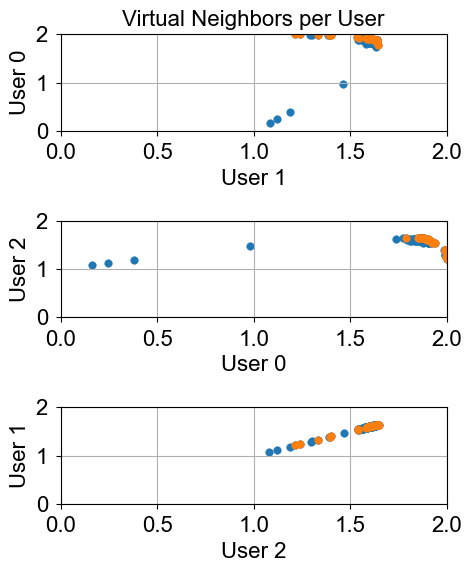

In [20]:
fig, axs = plt.subplots(3,sharey=False, sharex=False, figsize=[5,6])
labels = [1,0,2,1]
for i,ax in enumerate(axs):
    ax.scatter(x=vn[:,labels[i]], y=vn[:,labels[i+1]])
    ax.scatter(x=vn[:,labels[i]][filter], y=vn[:,labels[i+1]][filter])
    ax.set_xlabel(f'User {labels[i]}')
    ax.set_ylabel(f'User {labels[i+1]}')
    ax.set_ylim([0,2])
    ax.set_xlim([0,2])
    ax.grid()
axs[0].set_title('Virtual Neighbors per User')
plt.tight_layout()
plt.show()

In [21]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
virtual_neighbours['filter'] = filter
fig = px.scatter_3d(virtual_neighbours, x=virtual_neighbours.columns[0], y=virtual_neighbours.columns[1], z=virtual_neighbours.columns[2],
              color='filter')
plt.tight_layout()
fig.show()

<Figure size 640x440 with 0 Axes>

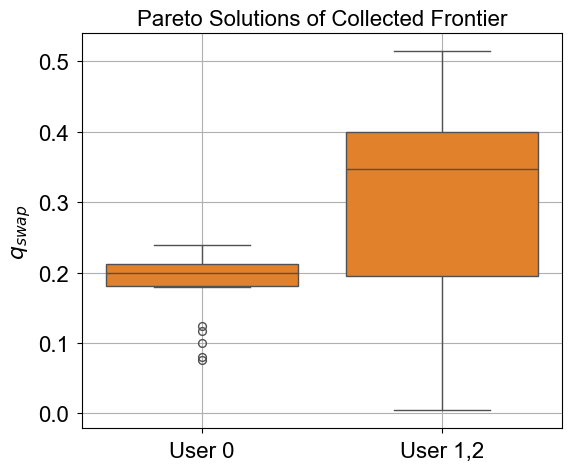

In [22]:
fig, ax = plt.subplots(figsize=(6,5))
g = sns.boxplot(model.X_df[filter].drop(['Iteration'], axis=1), palette=['tab:orange'])
g.set_xticklabels(['User 0', 'User 1,2'])
plt.ylabel(r'$q_{swap}$')
plt.title('Pareto Solutions of Collected Frontier')
plt.grid()
plt.tight_layout()
plt.savefig('cd-21tree-pareto.pdf')
plt.show()

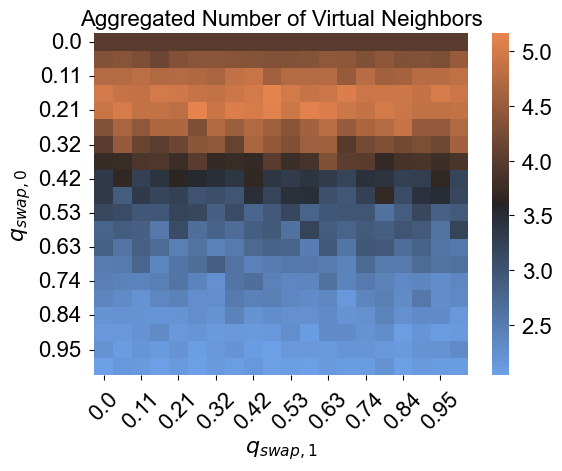

In [23]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
df_plot = pd.read_pickle('../usecase_cd/21tree-heatmap.pkl')
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_plot, cmap=cmap) #cbar_kws={'label': 'Aggregated Virtual Neighbors'}
plt.xlabel(r'$q_{swap,1}$')
plt.ylabel(r'$q_{swap,0}$')
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
plt.title('Aggregated Number of Virtual Neighbors')
plt.tight_layout()
plt.savefig('cd-21tree-heatmap.pdf')

In [121]:
folder = '../../surdata/cd_10h'
df, vals = read_pkl_surrogate(folder)
df = df.drop('index',axis=1)
vals['user']

(array([ 0,  1,  2,  3, 14, 16, 20, 22, 25, 29, 32, 33, 34, 35, 42, 44, 45,
        48, 49, 51, 52, 56, 60, 61, 66, 75, 76, 78, 82, 84, 85, 86, 88, 90,
        92, 94, 95, 97, 98]),)

In [122]:
n=100
graph = nx.random_tree(n, seed=7)

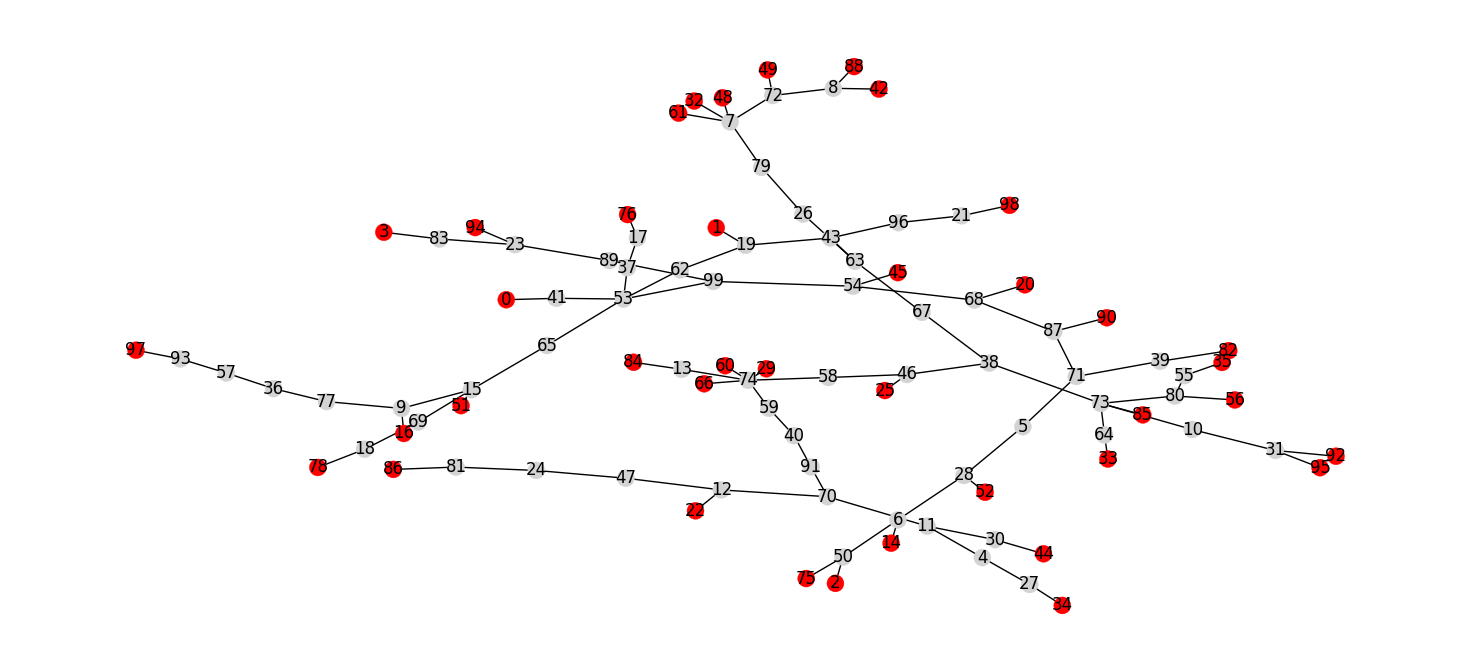

In [123]:
idx_degree_one = [key for key,value in dict(graph.degree).items() if value ==1]

fig, ax = plt.subplots(figsize=(15,7))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors = ['lightgrey'] * 100
for idx in idx_degree_one:
    colors[idx] = 'red'
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=150)
plt.tight_layout()

In [124]:
df_q_vn = df.drop(df.columns[df.columns.str.contains('std|Std|Method|Utility|Trial|Iteration')], axis=1)
vn = df_q_vn.drop(df.columns[df.columns.str.contains('q_swap')], axis=1)
vn.columns = vals['user'][0]
df_q = df_q_vn[df.columns[df.columns.str.contains('q_swap')]]

In [125]:
vn

,0,1,2,3,14,16,20,22,25,29,...,84,85,86,88,90,92,94,95,97,98
0,1.421053,2.210526,1.157895,1.263158,1.894737,1.789474,1.421053,1.315789,2.052632,1.421053,...,1.157895,1.842105,1.210526,1.894737,2.000000,1.210526,1.526316,1.157895,1.894737,1.105263
1,1.631579,1.263158,1.000000,2.052632,1.368421,1.631579,1.526316,1.210526,1.578947,1.263158,...,1.789474,1.052632,1.368421,2.052632,1.789474,2.052632,1.684211,1.736842,1.526316,1.578947
2,1.421053,1.842105,1.894737,1.526316,1.105263,1.578947,1.526316,2.000000,1.157895,1.210526,...,1.684211,1.210526,1.631579,1.578947,1.947368,1.789474,1.684211,1.526316,1.473684,0.842105
3,1.263158,1.315789,2.052632,1.947368,1.526316,1.473684,1.000000,1.631579,1.789474,1.473684,...,2.000000,1.473684,1.210526,1.105263,1.736842,1.578947,2.052632,1.578947,1.315789,1.526316
4,1.368421,1.157895,1.684211,1.315789,1.105263,1.052632,1.263158,1.421053,1.473684,1.263158,...,1.684211,1.368421,1.315789,1.473684,1.052632,1.789474,1.105263,1.947368,2.000000,1.263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9515,2.157895,2.578947,1.894737,2.210526,2.421053,2.210526,2.368421,2.526316,2.315789,1.736842,...,1.578947,1.894737,2.105263,2.000000,2.578947,2.368421,2.263158,2.157895,2.157895,1.526316
9516,1.947368,2.421053,2.210526,2.421053,2.368421,2.210526,2.157895,2.578947,2.368421,2.105263,...,1.842105,2.263158,2.105263,2.052632,2.473684,2.105263,2.315789,2.157895,2.157895,1.368421
9517,1.894737,1.947368,2.000000,2.421053,1.684211,2.000000,2.000000,2.526316,2.368421,1.684211,...,1.947368,2.000000,2.157895,2.000000,2.263158,2.105263,2.578947,2.263158,1.789474,2.263158
9518,1.947368,2.631579,2.526316,2.315789,2.210526,2.315789,1.947368,2.526316,1.736842,1.578947,...,1.736842,1.578947,2.473684,2.315789,2.000000,2.157895,2.210526,2.000000,1.631579,1.631579


In [266]:
# cluster 
spread = [44,90,20,66, 98,1]
cluster = [42,88,49,61,48,32]
cluster_small = [14, 75, 2]
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)


def get_pareto_frontier(vn, q_set, cluster = None):
    vn_to_analyse = vn if cluster == None else vn[cluster]
    filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
    return q_set[filter], sum(filter)

In [307]:
import re

def plot_errorbars(arg, **kws):
    np.random.seed(sum(map(ord, "error_bars")))
    x = np.random.normal(0, 1, 100)
    f, axs = plt.subplots(2, figsize=(7, 2), sharex=True, layout="tight")
    sns.pointplot(x=x, errorbar=arg, **kws, capsize=.3, ax=axs[0])
    sns.stripplot(x=x, jitter=.3, ax=axs[1])

def plot_paretoset(clusters=None):
    fig, ax = plt.subplots(figsize = [30,5])
    if clusters == None:
            vn_to_analyse = vn
            filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
            to_drop = (df_q[filter].std()>=0.25).values
            columns_to_drop = df_q.columns[to_drop]
            print(sum(filter))
            sns.boxplot(df_q[filter].drop(columns_to_drop, axis=1), palette={node: cmap(val) for node, val in dict(df_q[filter].mean()).items()})
    else:
        for cluster in clusters:
            vn_to_analyse = vn[cluster] 
            filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
            to_drop = (df_q[filter].std()>0.25).values
            columns_to_drop = df_q.columns[to_drop]
            print(sum(filter))
            sns.boxplot(df_q[filter].drop(columns_to_drop, axis=1), palette={node: cmap(val) for node, val in dict(df_q[filter].mean()).items()})
    labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
    plt.xlabel('Node')
    ax.set_xticklabels(labels)
    plt.ylabel(r'$q_{swap}$')
    plt.show()

9207


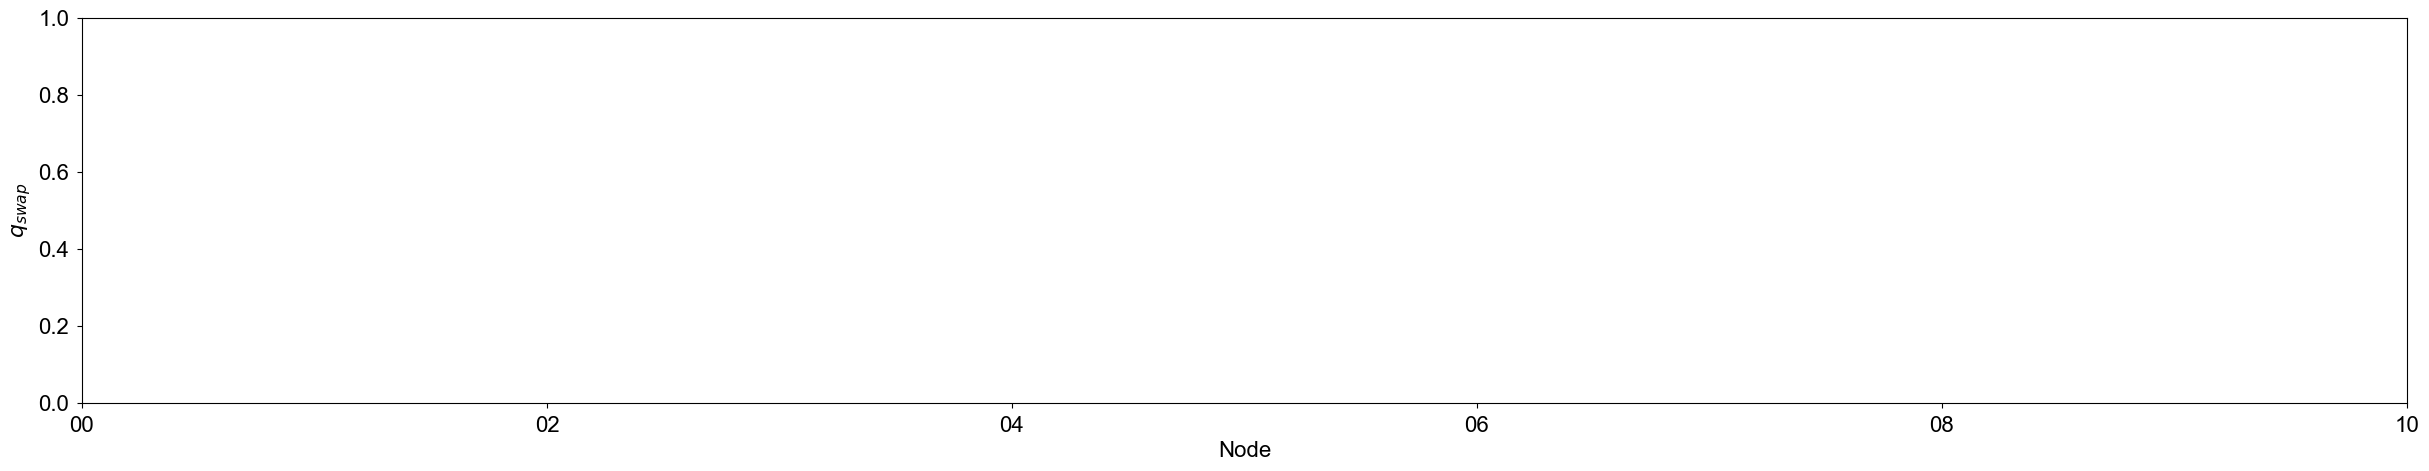

In [308]:
plot_paretoset()

538


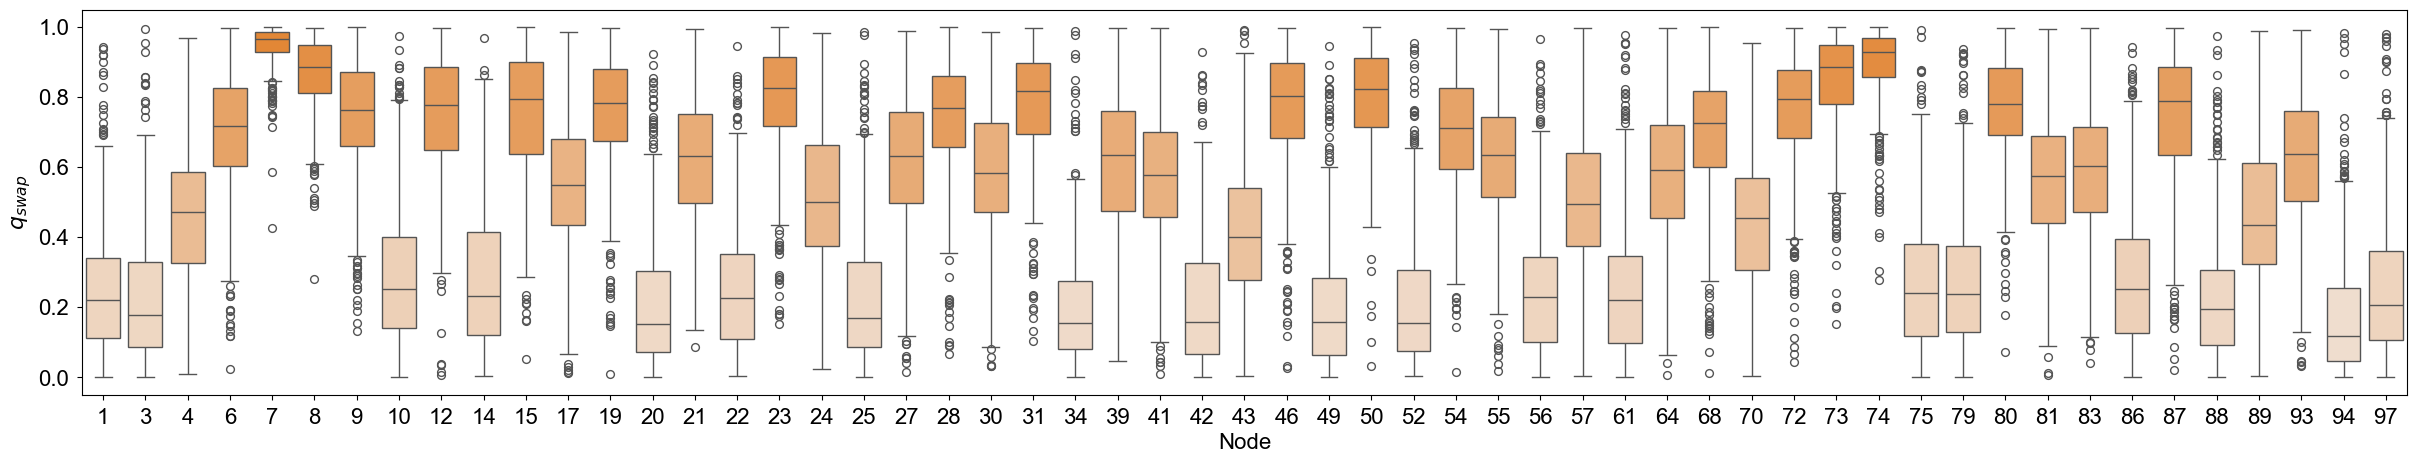

In [278]:
plot_paretoset(clusters=[cluster])

In [262]:
cmap = sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)

In [149]:
q_filtered_all, size_all = get_pareto_frontier(vn, df_q)

In [158]:
q_filtered_cluster, size_cluster = get_pareto_frontier(vn, df_q, cluster=cluster)

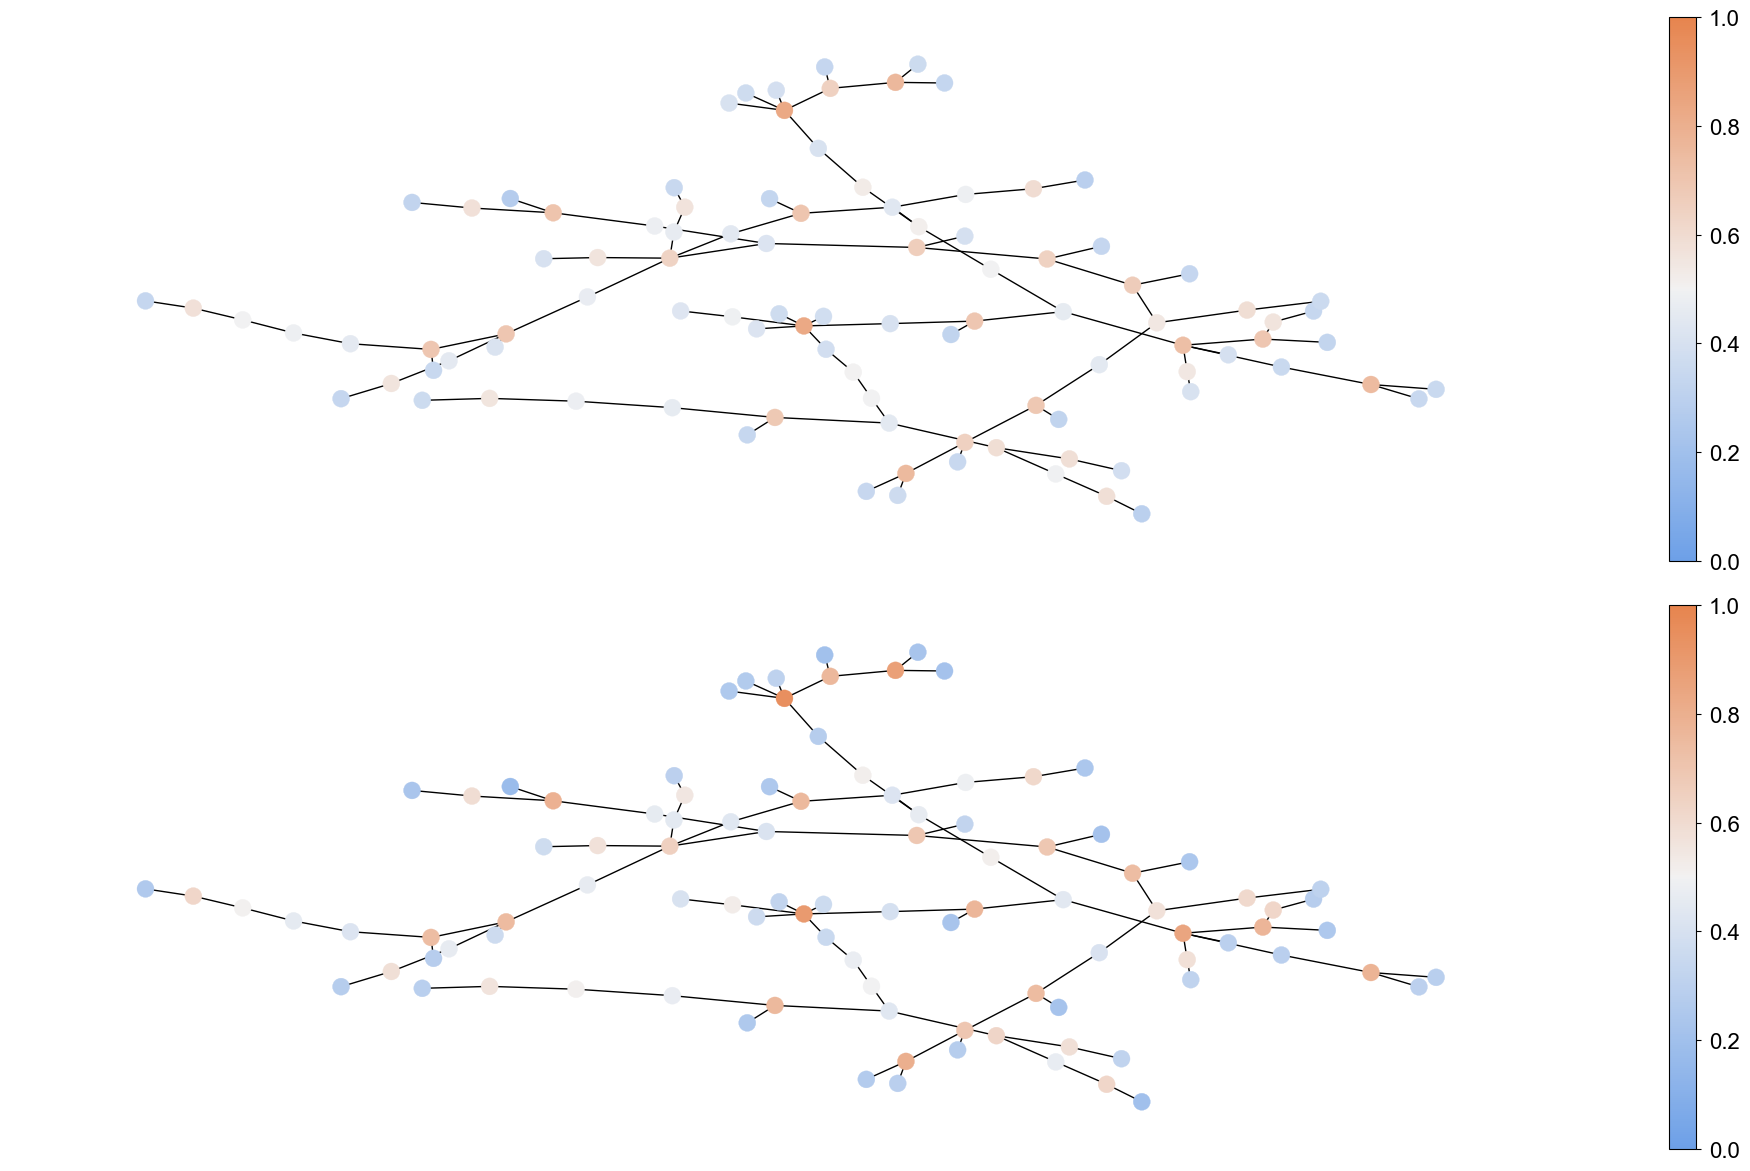

In [163]:
fig, axs = plt.subplots(2,1, figsize=(20,12))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors_all = [cmap(qswap_mean) for qswap_mean in q_filtered_all.mean().values]
nx.draw(graph, pos, with_labels=False, node_color=colors_all, node_size=150, ax=axs[0])
colors_cluster = [cmap(qswap_mean) for qswap_mean in q_filtered_cluster.mean().values]
nx.draw(graph, pos, with_labels=False, node_color=colors_cluster, node_size=150, ax=axs[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.colorbar(sm, ax=axs[0])
plt.colorbar(sm, ax=axs[1])
plt.tight_layout()

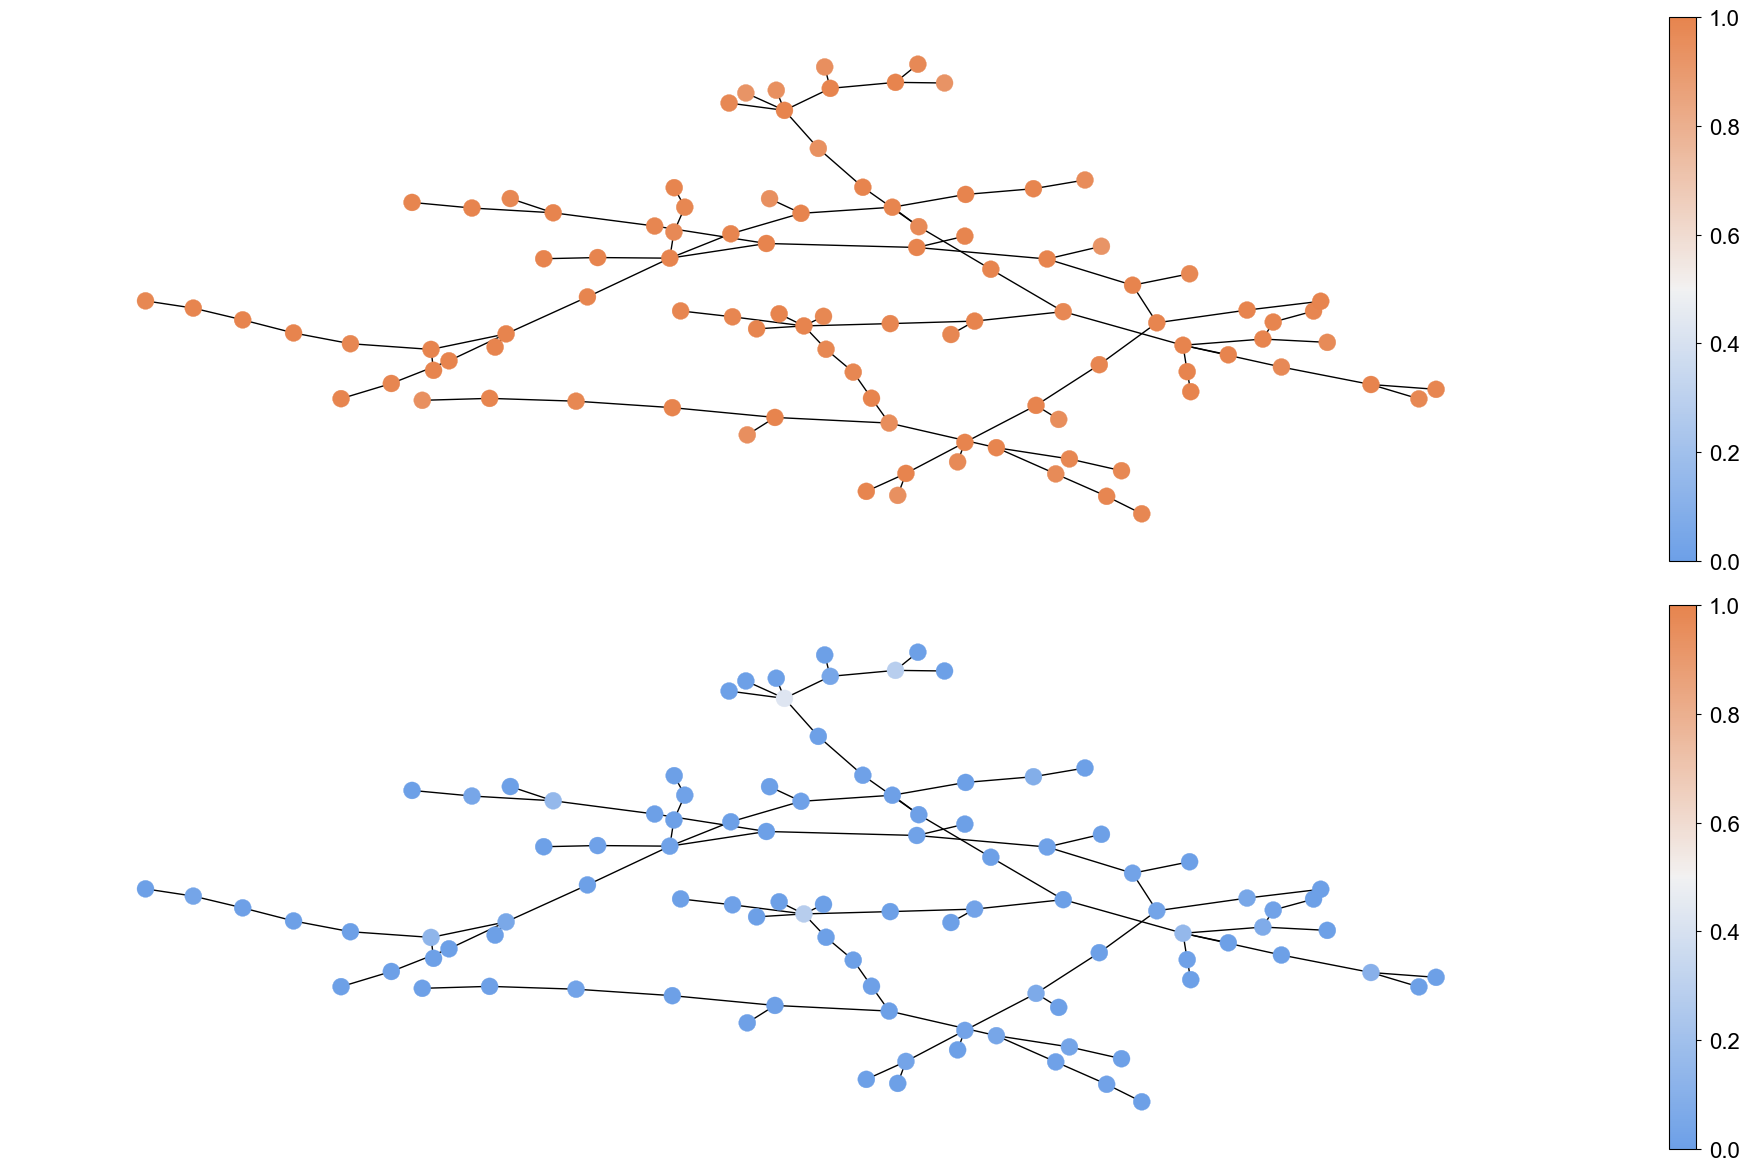

In [165]:
fig, axs = plt.subplots(2,1, figsize=(20,12))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors_max = [cmap(qswap_mean) for qswap_mean in q_filtered_cluster.max().values]
nx.draw(graph, pos, with_labels=False, node_color=colors_max, node_size=150, ax=axs[0])
colors_min = [cmap(qswap_mean) for qswap_mean in q_filtered_cluster.min().values]
nx.draw(graph, pos, with_labels=False, node_color=colors_min, node_size=150, ax=axs[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.colorbar(sm, ax=axs[0])
plt.colorbar(sm, ax=axs[1])
plt.tight_layout()

<Axes: ylabel='9516'>

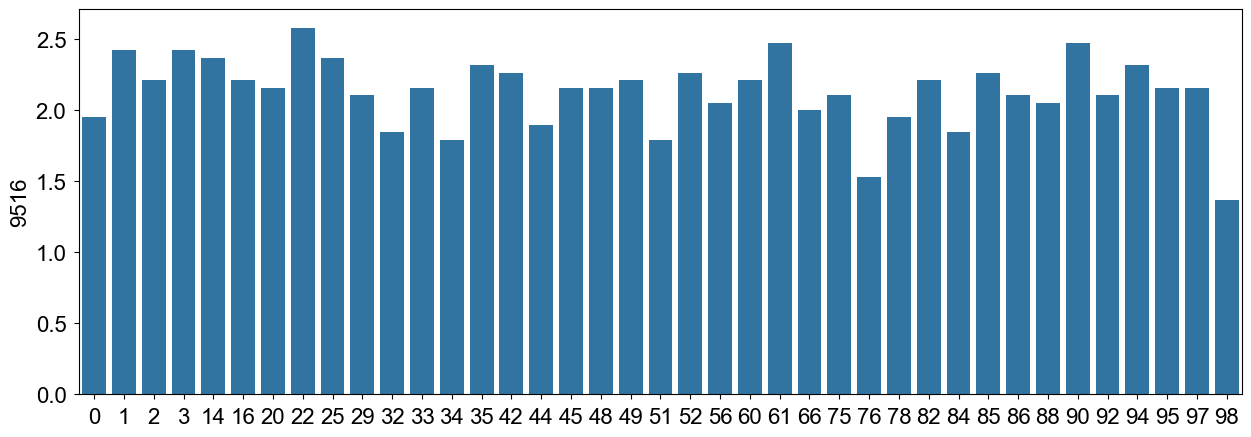

In [176]:
best_index = vn.sum(axis=1).idxmax()
fig, ax = plt.subplots(figsize=[15,5])
sns.barplot(vn.iloc[best_index])

In [179]:
graph.nodes(data=True)

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}, 52: {}, 53: {}, 54: {}, 55: {}, 56: {}, 57: {}, 58: {}, 59: {}, 60: {}, 61: {}, 62: {}, 63: {}, 64: {}, 65: {}, 66: {}, 67: {}, 68: {}, 69: {}, 70: {}, 71: {}, 72: {}, 73: {}, 74: {}, 75: {}, 76: {}, 77: {}, 78: {}, 79: {}, 80: {}, 81: {}, 82: {}, 83: {}, 84: {}, 85: {}, 86: {}, 87: {}, 88: {}, 89: {}, 90: {}, 91: {}, 92: {}, 93: {}, 94: {}, 95: {}, 96: {}, 97: {}, 98: {}, 99: {}})

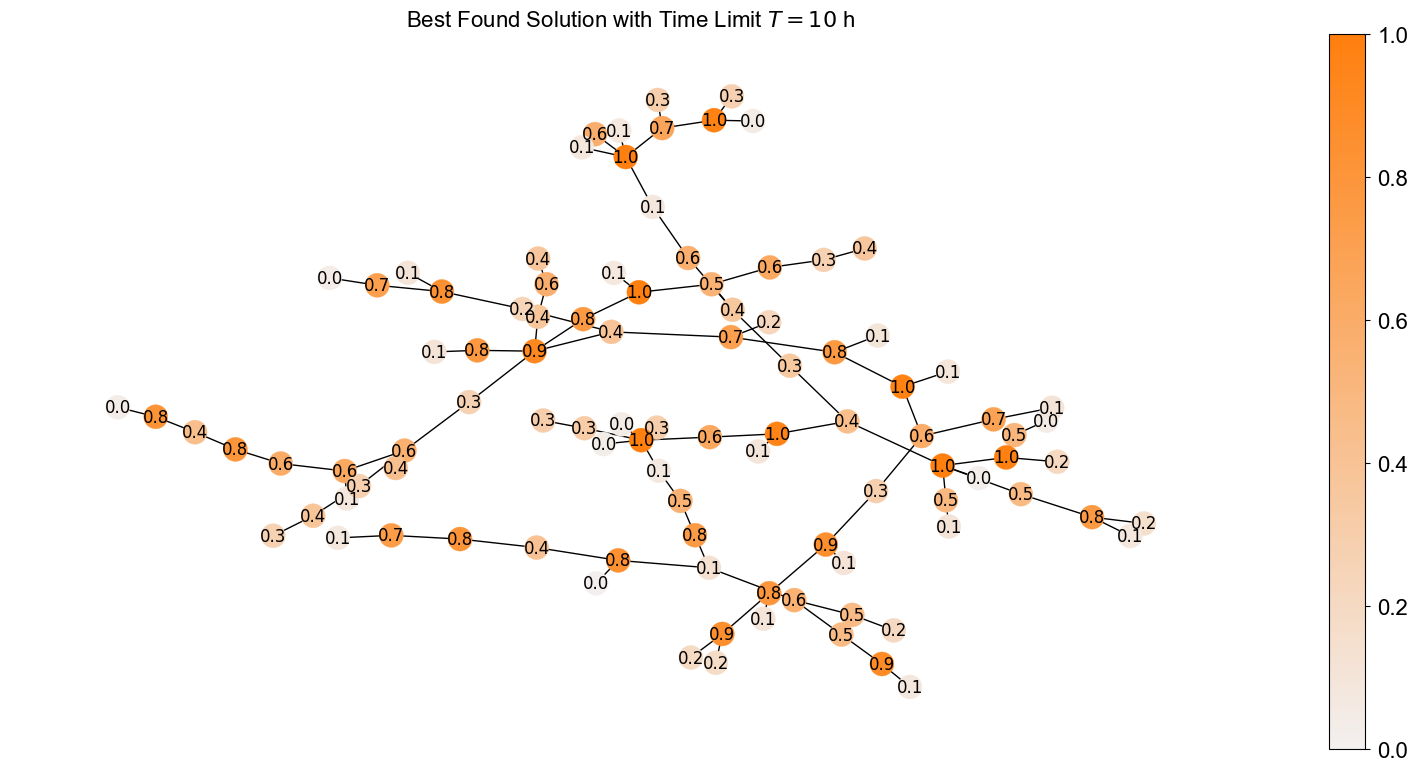

In [209]:
qvals = df_q.iloc[best_index]
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)
fig, ax = plt.subplots(figsize=(16,8))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors = [cmap(qswap_mean) for qswap_mean in qvals]
labels = {node: round(val,1) for node, val in enumerate(qvals)}
nx.draw(graph, pos, with_labels=False, node_color=colors, node_size=300)
nx.draw_networkx_labels(graph, pos, labels=labels)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.title(r'Best Found Solution with Time Limit $T = 10$ h')
plt.colorbar(sm, ax=ax)
plt.tight_layout()
plt.savefig('cd-random-tree-best.pdf')

In [78]:
vals['user']

(array([ 0,  1,  2,  3, 14, 16, 20, 22, 25, 29, 32, 33, 34, 35, 42, 44, 45,
        48, 49, 51, 52, 56, 60, 61, 66, 75, 76, 78, 82, 84, 85, 86, 88, 90,
        92, 94, 95, 97, 98]),)

214


0.24771357048096296

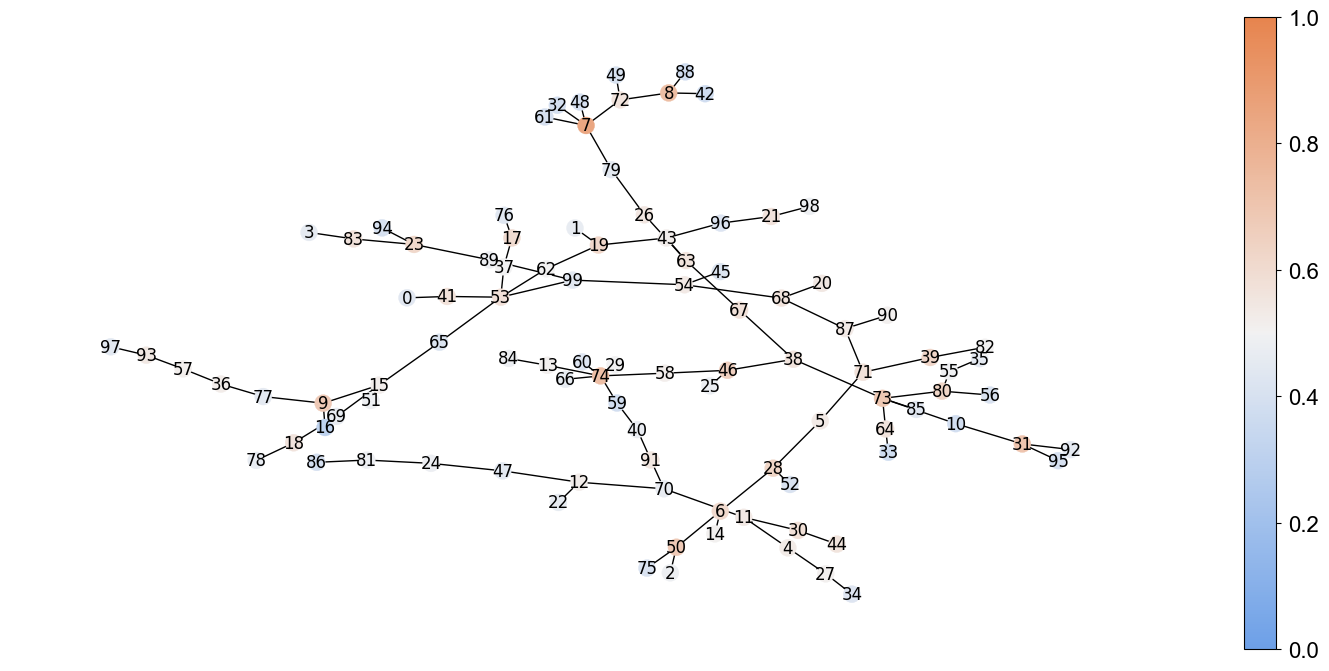

In [74]:
spread = [44,90,20,66, 98,1]
vn_to_analyse = vn[cluster]
filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
df_q_cluster= df_q[filter]

print(sum(filter))


fig, ax = plt.subplots(figsize=(15,7))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors = [cmap(qswap_mean) for qswap_mean in df_q_cluster.mean().values]
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=150)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.colorbar(sm, ax=ax)
plt.tight_layout()

np.mean(df_q_filtered.std().values)

195


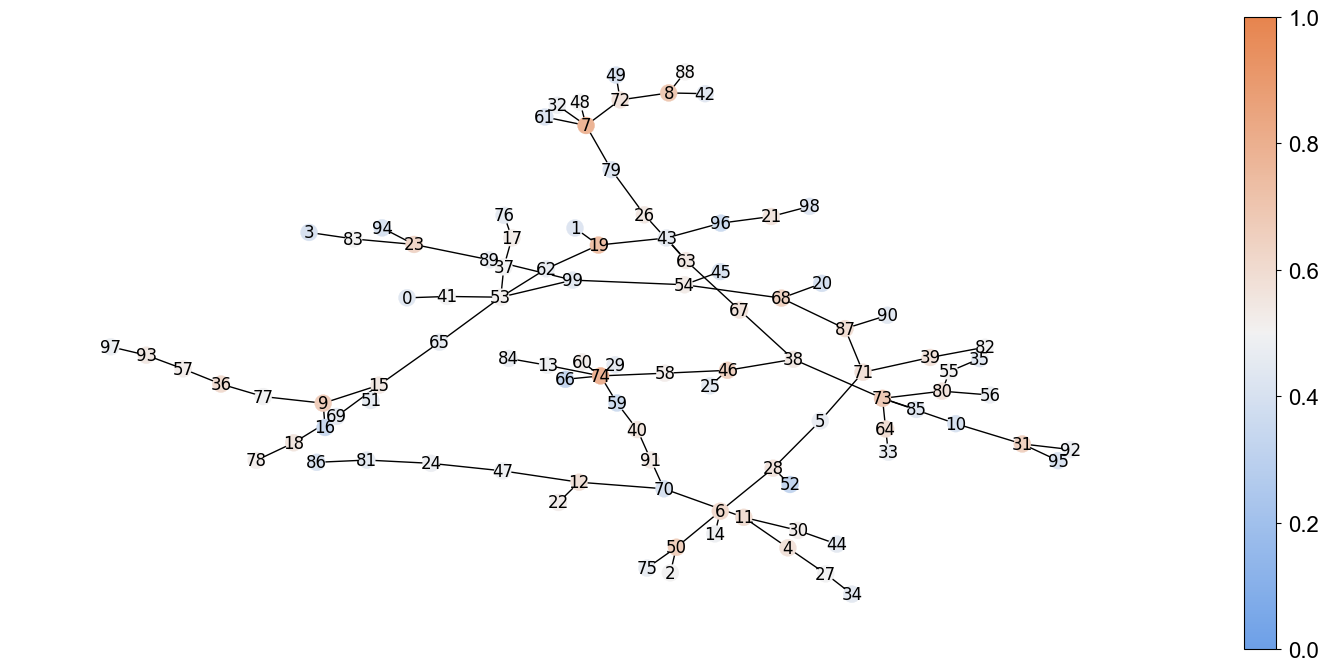

In [54]:
spread = [44,90,20,66, 98,1]
vn_to_analyse = vn[spread]
filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
df_q_spread = df_q[filter]

print(sum(filter))

fig, ax = plt.subplots(figsize=(15,7))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors = [cmap(qswap_mean) for qswap_mean in df_q_spread.mean().values]
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=150)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.colorbar(sm, ax=ax)
plt.tight_layout()

In [61]:
(df_q_cluster.mean()-df_q_spread.mean()).min()

-0.1252784054973034

In [3]:
plot_paretoset([vals['user'][0], cluster1, cluster2, cluster3])

NameError: name 'plot_paretoset' is not defined

In [4]:
plot_paretoset(cluster3)

NameError: name 'plot_paretoset' is not defined

In [5]:
sum(filter)

TypeError: 'type' object is not iterable

In [6]:
df_q_filtered.mean().values

NameError: name 'df_q_filtered' is not defined

PCA

In [190]:
from sklearn.decomposition import PCA

vn_to_analyse = vn[cluster]
filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
df_q_filtered = df_q[filter]

pca = PCA(n_components=10)
pca_results = pca.fit_transform(df_q_filtered)
pca_df = pd.DataFrame(data=pca_results, columns=[f'PC{i+1}' for i in range(pca_results.shape[1])])

loadings = pca.components_
loadings_df = pd.DataFrame(loadings, columns=df_q_filtered.columns, index=[f'PC{i+1}' for i in range(10)])

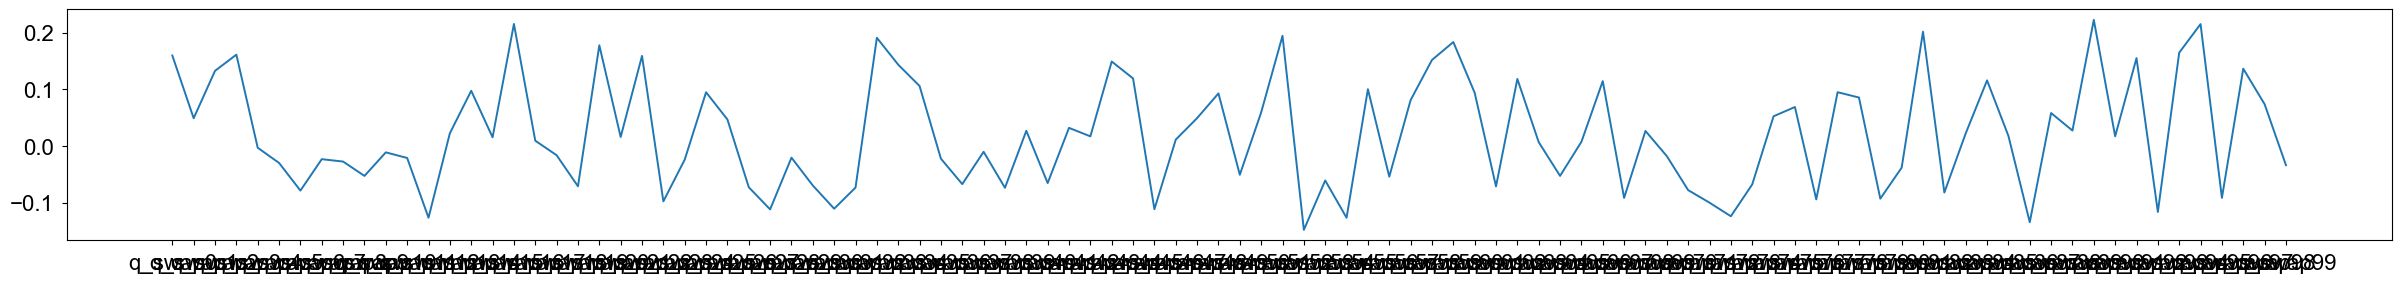

In [202]:
fig, ax = plt.subplots(figsize=(30,3))
plt.plot(loadings_df.iloc[0])

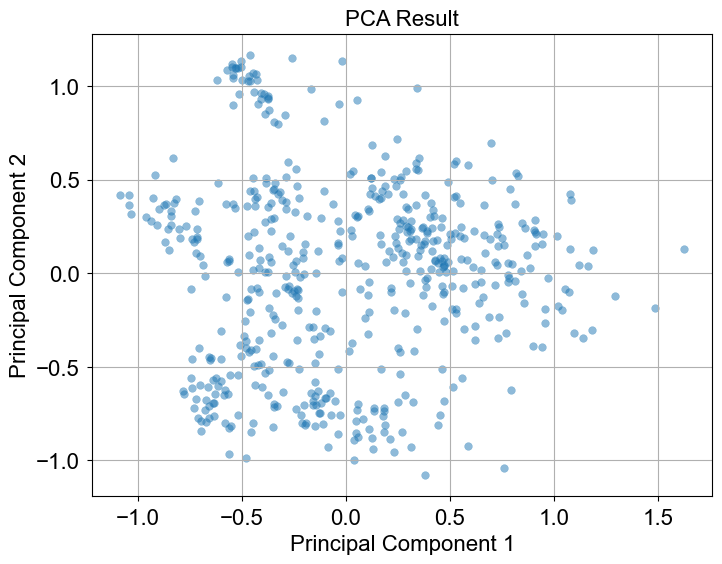

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.grid(True)
plt.show()

<div style="max-width:400px;margin-left: auto; margin-right: 0